In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as pnp
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

In [18]:
INPUT_SEQUENCE_LENGTH = 168 
OUTPUT_SEQUENCE_LENGTH = 72 
N_LOCATIONS = 400

In [19]:
n_qubits = 4
n_layers = 1

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = qml.device("lightning.qubit", wires=n_qubits)

In [21]:
@qml.qnode(dev, interface="torch")
def q_circuit(inputs, weights):
    """A quantum circuit that acts as a feature extractor."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [22]:
class QLSTMModel(nn.Module):
    """
    Hybrid Quantum-Classical model for multi-step forecasting.
    A classical LSTM processes the sequence, and its output is fed
    into a quantum circuit for feature extraction, followed by a
    classical layer for multi-step prediction.
    """
    def __init__(self, n_features, n_lstm_units=4, n_qubits=2, num_layers=1, n_layers=1, output_len=OUTPUT_SEQUENCE_LENGTH):
        super(QLSTMModel, self).__init__()

        # 1. Classical LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=num_layers,
            batch_first=True
        )
        
        # 2. Classical Layer to map LSTM output to Quantum input
        self.classical_to_quantum = nn.Linear(n_lstm_units, n_qubits)
        
        # 3. Quantum Layer
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(q_circuit, weight_shapes)
        
        # 4. Classical Layer to map quantum output to predictions
        self.quantum_to_output = nn.Linear(n_qubits, output_len)
        
    def forward(self, x):        
        # 1. Pass data through the classical LSTM
        lstm_out, _ = self.lstm(x)
        
        # 2. Extract features from the last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Prepare the data for the quantum circuit
        quantum_input = self.classical_to_quantum(final_lstm_output)
        
        # 4. Pass the features through the quantum circuit
        quantum_features = self.q_layer(quantum_input)
        
        # 5. Map quantum features to output sequence
        output = self.quantum_to_output(quantum_features)
        
        # 6. Apply sigmoid activation to get probabilities
        return torch.sigmoid(output)

In [23]:
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    if not os.path.exists('air_quality_all_preproccessed.parquet'):
        raise FileNotFoundError("The data file 'air_quality_all_preproccessed.parquet' was not found.")
    df = pq.read_table('air_quality_all_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")

    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    df = df.sort_values(['location_encoded', 'year', 'month', 'day', 'hour'])

    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'year', 'month', 'day', 'hour', 'location_encoded'
    ]]
    feature_columns.append('location_encoded')

    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")

    return df, feature_columns, le_location

In [24]:
def create_sequences_memory_efficient(df, feature_columns,
                                    input_len=INPUT_SEQUENCE_LENGTH,
                                    output_len=OUTPUT_SEQUENCE_LENGTH,
                                    stride=24):
    """
    Create sequences for multi-step forecasting.
    Input: `input_len` hours of data
    Output: `output_len` hours of predictions
    """
    print(f"Creating sequences with input length={input_len}, output length={output_len}...")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)

    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()

    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values

        # Calculate valid range to ensure we have enough data for output sequence
        max_start_idx = len(loc_df) - input_len - output_len

        for j in range(0, max_start_idx, stride):
            X_seq = loc_X.iloc[j : j + input_len].values
            # Get the next `output_len` hours of class data
            y_target = loc_y[j + input_len : j + input_len + output_len]

            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)

        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")

    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)

    print(f"Total sequences: {X_sequences.shape[0]}")
    print(f"Input sequence shape: {X_sequences.shape}")
    print(f"Output sequence shape: {y_sequences.shape}")

    return X_sequences, y_sequences, location_indices, scaler

In [25]:
def train_model_pytorch(model, train_loader, val_loader, epochs=10, patience=3):
    """Trains the PyTorch model for multi-step forecasting."""
    print("Starting training with PyTorch...")
    model.to(device)
    
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    history = defaultdict(list)
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss, train_correct, train_samples = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_samples += y_batch.size(0) * y_batch.size(1)  
        
        train_loss /= train_samples
        train_acc = train_correct / train_samples
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_samples += y_batch.size(0) * y_batch.size(1)
        
        val_loss /= val_samples
        val_acc = val_correct / val_samples
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        scheduler.step(val_loss)
        
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Duration: {epoch_duration:.2f}s")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_qlstm_model_multistep.pth')
            patience_counter = 0
            print("  -> Validation loss improved. Saving model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  -> Early stopping triggered.")
                break
                
    model.load_state_dict(torch.load('best_qlstm_model_multistep.pth'))
    return model, history

In [26]:
def plot_training_history(history):
    """Plot training history for multi-step forecasting"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    ylabel = 'Accuracy (per timestep)'
    plt.ylabel(ylabel)
    plt.legend()

    plt.tight_layout()
    plt.savefig('classical_training_history_multistep.png', dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        # Get predictions for first few test samples
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)

        plt.figure(figsize=(15, 5 * num_examples))

        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]

            # Get prediction
            y_pred = model(X_sample).cpu().numpy()[0]
            y_pred = (y_pred > 0.5).astype(int)

            # Plot
            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, OUTPUT_SEQUENCE_LENGTH + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [28]:
def evaluate_model_per_location_and_hour(model, test_loader, device, location_indices_test):
    """Evaluate model to get accuracy per location and per hour"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)  # shape: (n_samples, 72)
    all_labels = np.concatenate(all_labels, axis=0)  # shape: (n_samples, 72)
    
    # Calculate accuracy per location
    unique_locations = np.unique(location_indices_test)
    location_acc = {}
    for loc in unique_locations:
        idx = (location_indices_test == loc)
        preds_loc = all_preds[idx]
        labels_loc = all_labels[idx]
        acc = (preds_loc == labels_loc).mean()
        location_acc[loc] = acc
    
    # Calculate accuracy per hour
    hour_acc = np.zeros(OUTPUT_SEQUENCE_LENGTH)
    for hour in range(OUTPUT_SEQUENCE_LENGTH):
        preds_hour = all_preds[:, hour]
        labels_hour = all_labels[:, hour]
        hour_acc[hour] = (preds_hour == labels_hour).mean()
    
    return location_acc, hour_acc

In [29]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [30]:
df, feature_columns, le_location = load_and_prepare_data()

# Create sequences with configurable lengths
X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
    df, 
    feature_columns, 
    input_len=INPUT_SEQUENCE_LENGTH,
    output_len=OUTPUT_SEQUENCE_LENGTH,
    stride=24
)

# Split data
X_train, X_test, y_train, y_test, loc_train, loc_test = train_test_split(
    X_sequences, y_sequences, location_indices, 
    test_size=0.2, random_state=42, stratify=location_indices
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")


Loading data...
Dataset shape: (14006400, 14)
Feature columns: ['PM25_MERRA2', 'DUCMASS', 'TOTANGSTR', 'DUFLUXV', 'SSFLUXV', 'DUFLUXU', 'BCCMASS', 'SSSMASS25', 'location_encoded']
Number of features: 9
Creating sequences with input length=168, output length=72...
Processed location 100/400
Processed location 200/400
Processed location 300/400
Processed location 400/400
Total sequences: 579600
Input sequence shape: (579600, 168, 9)
Output sequence shape: (579600, 72)
Training set shape: (463680, 168, 9)
Test set shape: (115920, 168, 9)
Training target shape: (463680, 72)
Test target shape: (115920, 72)


In [32]:
batch_size = 512

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Keep test data for evaluation
X_test_plot = X_test.copy()
y_test_plot = y_test.copy()

# Clean up memory
del X_sequences, y_sequences, location_indices, X_train, y_train, loc_train
gc.collect()

8

In [33]:
n_lstm_units = 16
num_layers = 1

model = QLSTMModel(
    n_features=len(feature_columns), 
    n_lstm_units=n_lstm_units,  
    n_qubits=n_qubits,
    num_layers=num_layers,
    n_layers=n_layers,
    output_len=OUTPUT_SEQUENCE_LENGTH
)
print("\nHybrid Quantum-Classical LSTM Model Architecture:")
print(model)


Hybrid Quantum-Classical LSTM Model Architecture:
QLSTMModel(
  (lstm): LSTM(9, 16, batch_first=True)
  (classical_to_quantum): Linear(in_features=16, out_features=4, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit>
  (quantum_to_output): Linear(in_features=4, out_features=72, bias=True)
)


In [ ]:
model, history = train_model_pytorch(model, train_loader, val_loader, epochs=5, patience=5)

Starting training with PyTorch...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7d7e3d8d3ac0>>
Traceback (most recent call last):
  File "/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
plot_training_history(history)

In [ ]:
print("\nCalculating detailed accuracy metrics...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model per location and per hour
location_acc, hour_acc = evaluate_model_per_location_and_hour(
    model, val_loader, device, loc_test
)

In [ ]:
print("\nPer-location accuracy (averaged over all 72 hours):")
for loc in sorted(location_acc.keys()):
    print(f"Location {loc}: {location_acc[loc]:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(list(location_acc.values()), bins=20, edgecolor='black')
plt.title('Distribution of Per-Location Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Number of Locations')
plt.grid(True)
plt.savefig('location_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\nPer-hour accuracy (averaged over all locations):")
for hour in range(OUTPUT_SEQUENCE_LENGTH):
    print(f"Hour {hour+1}: {hour_acc[hour]:.4f}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, OUTPUT_SEQUENCE_LENGTH + 1), hour_acc, marker='o')
plt.title('Accuracy per Forecast Hour')
plt.xlabel('Hour Ahead')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('hour_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


Generating example predictions...


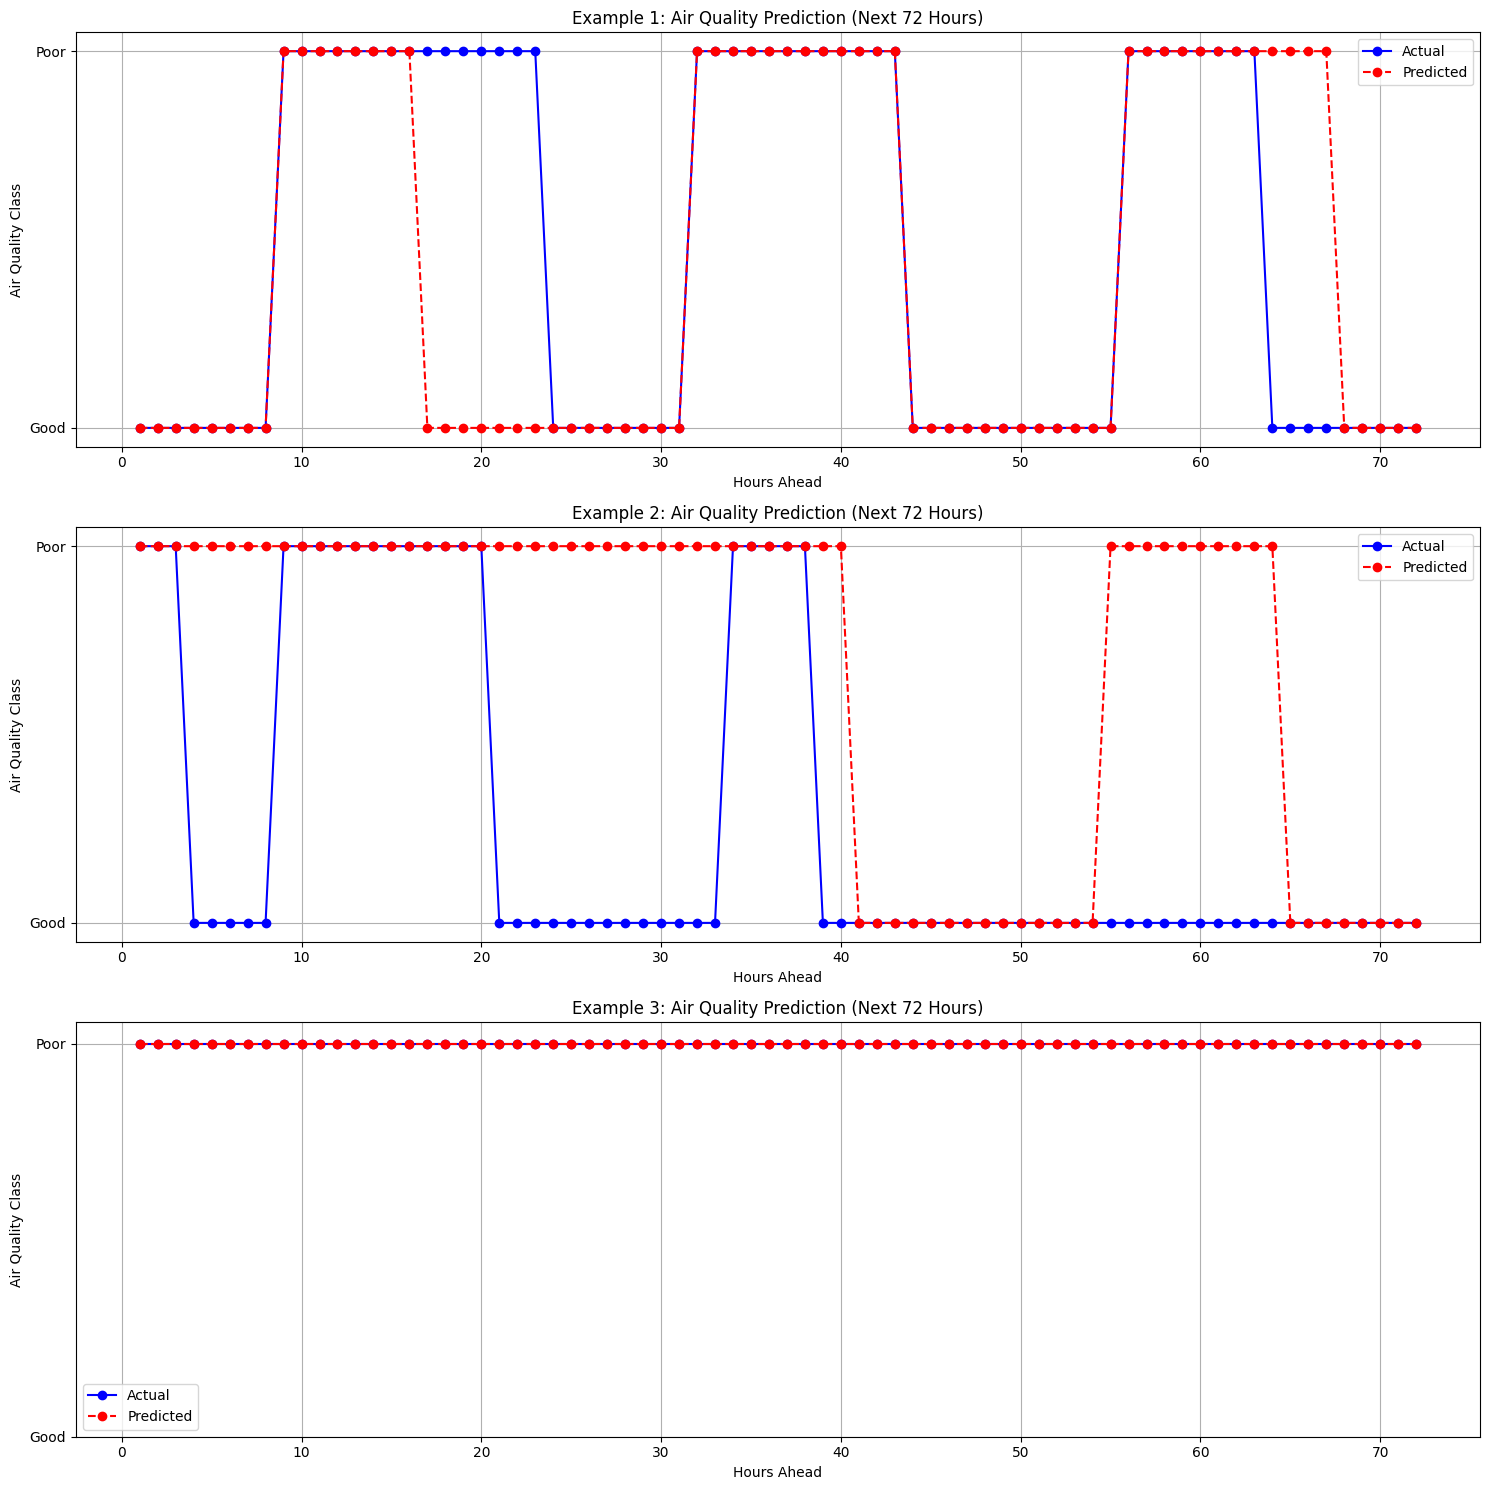

In [19]:
print("\nGenerating example predictions...")
X_test_plot = []
y_test_plot = []
for X_batch, y_batch in val_loader:
    X_test_plot.append(X_batch)
    y_test_plot.append(y_batch)
X_test_plot = torch.cat(X_test_plot, dim=0).numpy()
y_test_plot = torch.cat(y_test_plot, dim=0).numpy()

plot_example_predictions(model, X_test_plot, y_test_plot, num_examples=3)